In [1]:
import pandas as pd
import random
import numpy as np
import torch
from tensorboardX import SummaryWriter
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(7)

In [2]:
numerical_data = pd.read_csv('all_after_preprocessingStopwords.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
def Data_preprocessing(df):
    scaler = MinMaxScaler()
    
    # Numerical Feature
    numerical_features = ["bedroom","bedroomAboveGrade","bedroomBelowGrade","bathroom", "bathroomTotal","bathroomPartial", 
                        "totalParkingSpaces", "storeys", "maintenanceFees",  'landSize']
    
    X_num = df[numerical_features]
    X_num = scaler.fit_transform(X_num)
    X_num = pd.DataFrame(X_num)
    df["longitude"] = df["longitude"] *0.01
    df["latitude"] = df["latitude"] *0.01
    df[numerical_features] = X_num
          
    # Boolean Feature
    boolean_features=['parkingAttachedGarage',
       'parkingUnderground', 'parkingInsideEntry', 'parkingSurfaced',
       'parkingOversize', 'parkingGravel', 'parkingGarage', 'parkingShared',
       'parkingDetachedGarage', 'parkingCarport', 'parkingInterlocked',
       'parkingVisitorParking','amenityClubhouse', 'amenityCarWash', 'amenityMusicRoom',
       'amenityStorageLocker', 'amenitySauna', 'amenityPartyRoom',
       'amenityRecreationCentre', 'amenityGuestSuite', 'amenityFurnished',
       'amenityLaundryFacility', 'amenityExerciseCentre',
       'amenityLaundryInSuite', 'amenitySecurity', 'amenityWhirlpool',
       'efinishWood', 'efinishBrick', 'efinishHardboard', 'efinishWoodsiding',
       'efinishLog', 'efinishMetal', 'efinishSteel', 'efinishStone',
       'efinishWoodshingles', 'efinishStucco', 'efinishSiding',
       'efinishConcrete', 'efinishShingles', 'efinishAluminumsiding',
       'efinishCedarshingles', 'efinishVinyl', 'efinishVinylsiding',
       'featurePetNotAllowed', 'AirportNearby',
       'GolfNearby', 'MarinaNearby', 'ShoppingNearby', 'WaterNearby',
       'WorshipPlaceNearby', 'RecreationNearby', 'PlaygroundNearby',
       'PublicTransitNearby', 'ParkNearby', 'SchoolsNearby', 'HospitalNearby',
       'HighwayNearby', 'SkiAreaNearby']
    
    # Category Feature
    cate_features = ['city', 'typeBuilding', 'title', 'styleAttach', 
                   'cooling',  'basementType', 'basementFinish',
                   'heatingType1', 'heatingType2', 'heatingEnergy1', 'heatingEnergy2', 
                   'featureLotSlope', 'featureDriveway', 'featureLotPositionType',
       'featureOutdoorAreaType', 'featureOutdoorLandscape',
       'featureAdditionalFacility']
    
    X_category=df[cate_features]
    for col in cate_features:
        X_category[col] = X_category[col].astype('category')
        X_category[col] = X_category[col].cat.codes
    df[cate_features] = X_category
    
    # Label Price
    price_range = []
    
    for price in df["price"]:
        if price < 5e5:
            price_range.append(0)
        elif 5e5<=price < 15e5:
            price_range.append(1)
        elif 15e5<=price < 25e5:
            price_range.append(2)
        elif 25e5<=price < 35e5:
            price_range.append(3)
        elif 35e5<=price < 80e5:
            price_range.append(4)
        else:
            price_range.append(5)
            
#     df = df.reset_index(drop=True)
    df['price_range'] = price_range
    df = df.dropna()
    return df, boolean_features, cate_features, numerical_features

In [4]:
from sklearn.model_selection import train_test_split
preprocessed_data, boolean_features, cate_features, numerical_features = Data_preprocessing(numerical_data)

<ipython-input-3-f5456da299cf>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].astype('category')
<ipython-input-3-f5456da299cf>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].cat.codes


In [5]:
cate_num = len(cate_features)
bool_num =  len(boolean_features)
num_num = len(numerical_features)
print('The number of categorical feature is : {}, boolean feature is : {}, numerical feature is : {}'.format(cate_num, bool_num, num_num))

The number of categorical feature is : 17, boolean feature is : 58, numerical feature is : 10


In [6]:
class Generate_dataset(Dataset):
    def __init__(self, data_df, boolean_features,cate_features, numerical_features):
        self.MAX_SEQ_LEN = 128
        self.data = data_df
        self.boolean = boolean_features
        self.cate = cate_features
        self.numerical = numerical_features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()

        boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
        cate_feature = torch.tensor(list(self.data.iloc[idx][self.cate]))
        numerical_feature = torch.tensor(list(self.data.iloc[idx][self.numerical]))
        description = self.data.iloc[idx]['description']
        label = torch.tensor(float(self.data.iloc[idx]['price']))
        label_range =  torch.tensor(int(self.data.iloc[idx]['price_range']))
        
        return {'numerical_feature':numerical_feature, 'cate_feature':cate_feature, 'boolean_feature':boolean_feature, 'label':label, 'label_range':label_range}

In [7]:
X_train, X_test = train_test_split(preprocessed_data, test_size=0.1, random_state=13) 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [8]:
Train_dataset = Generate_dataset(X_train, boolean_features,cate_features, numerical_features)
Test_dataset = Generate_dataset(X_test,boolean_features,cate_features, numerical_features)

In [9]:
batch_size = 64
Train_dataloader = DataLoader(Train_dataset, batch_size = batch_size)
Test_dataloader = DataLoader(Test_dataset, batch_size = batch_size)

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

In [11]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = torch.nn.Embedding(6, 10)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(95, 190),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(190, 380),            
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(380, 190),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(190, 85), 
            torch.nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 85)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x.float())
        return out

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = torch.nn.Embedding(6, 10)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(95, 190),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(190, 95),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(95, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        x = x.view(x.size(0), 85)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x.float())
        return out.squeeze()

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [14]:
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4)

In [15]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 85)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 6, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [16]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 85)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 6, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [17]:
from torch.autograd import Variable
from tqdm import tqdm
writer = SummaryWriter()
num_epochs = 50
n_critic = 1
display_step = 50
d_loss_all = []
g_loss_all = []
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, data in tqdm(enumerate(Train_dataloader)):
        step = epoch * len(Train_dataloader) + i + 1
        
        real_images = torch.cat((data['numerical_feature'], data['cate_feature'], data['boolean_feature']), dim = -1).to(device)
        labels = data['label_range'].to(device)
        generator.train() 
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        g_loss_all.append(g_loss)
        d_loss_all.append(d_loss / n_critic)
        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)  
#     print('Done!')

0it [00:00, ?it/s]

Starting epoch 0... 

<ipython-input-6-1bce34b6507c>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
145it [01:02,  2.33it/s]
0it [00:00, ?it/s]

Starting epoch 1... 

145it [01:01,  2.36it/s]
0it [00:00, ?it/s]

Starting epoch 2... 

145it [01:00,  2.40it/s]
0it [00:00, ?it/s]

Starting epoch 3... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 4... 

145it [01:01,  2.36it/s]
0it [00:00, ?it/s]

Starting epoch 5... 

145it [01:02,  2.31it/s]
0it [00:00, ?it/s]

Starting epoch 6... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 7... 

145it [01:00,  2.40it/s]
0it [00:00, ?it/s]

Starting epoch 8... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 9... 

145it [01:04,  2.24it/s]
0it [00:00, ?it/s]

Starting epoch 10... 

145it [01:03,  2.27it/s]
0it [00:00, ?it/s]

Starting epoch 11... 

145it [01:01,  2.36it/s]
0it [00:00, ?it/s]

Starting epoch 12... 

145it [01:00,  2.41it/s]
0it [00:00, ?it/s]

Starting epoch 13... 

145it [01:01,  2.34it/s]
0it [00:00, ?it/s]

Starting epoch 14... 

145it [01:02,  2.34it/s]
0it [00:00, ?it/s]

Starting epoch 15... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 16... 

145it [00:59,  2.45it/s]
0it [00:00, ?it/s]

Starting epoch 17... 

145it [01:03,  2.27it/s]
0it [00:00, ?it/s]

Starting epoch 18... 

145it [01:04,  2.25it/s]
0it [00:00, ?it/s]

Starting epoch 19... 

145it [01:02,  2.32it/s]
0it [00:00, ?it/s]

Starting epoch 20... 

145it [01:02,  2.34it/s]
0it [00:00, ?it/s]

Starting epoch 21... 

145it [01:03,  2.28it/s]
0it [00:00, ?it/s]

Starting epoch 22... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 23... 

145it [00:59,  2.44it/s]
0it [00:00, ?it/s]

Starting epoch 24... 

145it [01:02,  2.30it/s]
0it [00:00, ?it/s]

Starting epoch 25... 

145it [01:01,  2.36it/s]
0it [00:00, ?it/s]

Starting epoch 26... 

145it [01:05,  2.21it/s]
0it [00:00, ?it/s]

Starting epoch 27... 

145it [01:01,  2.37it/s]
0it [00:00, ?it/s]

Starting epoch 28... 

145it [01:02,  2.33it/s]
0it [00:00, ?it/s]

Starting epoch 29... 

145it [00:58,  2.46it/s]
0it [00:00, ?it/s]

Starting epoch 30... 

145it [01:02,  2.31it/s]
0it [00:00, ?it/s]

Starting epoch 31... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 32... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 33... 

145it [00:59,  2.44it/s]
0it [00:00, ?it/s]

Starting epoch 34... 

145it [01:00,  2.41it/s]
0it [00:00, ?it/s]

Starting epoch 35... 

145it [00:59,  2.42it/s]
0it [00:00, ?it/s]

Starting epoch 36... 

145it [01:00,  2.40it/s]
0it [00:00, ?it/s]

Starting epoch 37... 

145it [01:02,  2.33it/s]
0it [00:00, ?it/s]

Starting epoch 38... 

145it [26:26, 10.94s/it] 
1it [00:00,  7.01it/s]

Starting epoch 39... 

145it [00:18,  7.65it/s]
1it [00:00,  7.83it/s]

Starting epoch 40... 

145it [00:18,  7.70it/s]
1it [00:00,  7.06it/s]

Starting epoch 41... 

145it [00:19,  7.45it/s]
1it [00:00,  7.54it/s]

Starting epoch 42... 

145it [00:19,  7.54it/s]
1it [00:00,  7.48it/s]

Starting epoch 43... 

145it [00:39,  3.64it/s]
0it [00:00, ?it/s]

Starting epoch 44... 

145it [01:02,  2.31it/s]
0it [00:00, ?it/s]

Starting epoch 45... 

145it [01:03,  2.29it/s]
0it [00:00, ?it/s]

Starting epoch 46... 

145it [01:00,  2.41it/s]
0it [00:00, ?it/s]

Starting epoch 47... 

145it [01:00,  2.40it/s]
0it [00:00, ?it/s]

Starting epoch 48... 

145it [01:00,  2.39it/s]
0it [00:00, ?it/s]

Starting epoch 49... 

145it [00:59,  2.43it/s]


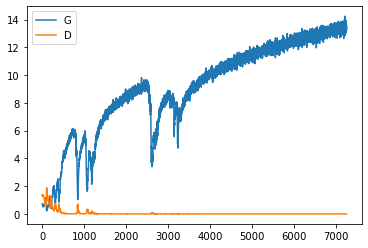

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(len(g_loss_all)),g_loss_all, label = 'G')
plt.plot(range(len(d_loss_all)),d_loss_all, label = 'D')
plt.legend()
plt.show()

In [23]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 85)).cuda()
    label = torch.LongTensor([digit]).cuda()
    res = generator(z, label).data.cpu()
    return res

In [24]:
generate_digit(generator, 1)

tensor([[ 1.2078,  0.4072, -0.9258, -0.5508, -0.4287, -0.9009,  1.6090, -0.9375,
         -1.1909,  0.4488,  1.1478, -0.2309,  1.6217, -0.5767, -0.4095, -0.5136,
          0.5343,  0.1418, -0.3465,  0.2850, -0.7525,  1.3930,  0.1178,  0.9939,
          1.2734, -0.2707,  0.0507, -0.2507,  0.2944, -0.6278, -1.9295, -0.4616,
          0.6243, -0.5223, -0.6716,  0.2630,  0.1682,  0.4599, -0.4506, -0.4612,
         -0.8433, -1.4537, -1.1187, -0.3316,  0.3775, -1.4688,  1.1789,  1.4299,
         -0.6119,  0.0393, -0.1937, -0.6453,  0.3555, -0.3404, -2.3617, -1.3288,
         -0.0480,  0.3660, -0.6354,  1.0839, -0.6650,  2.4299,  1.3050,  0.4760,
         -0.3944, -0.8595,  0.9133, -0.2038, -0.6334, -1.1944,  0.8256,  1.0809,
         -0.3963,  0.1628,  1.0090, -1.6068,  0.4202, -0.5998,  0.0722,  1.1313,
         -0.9784,  0.6131, -0.0823,  0.3840,  0.1771]], device='cuda:0')


tensor([[-1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
          1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
          1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
         -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
          1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
          1.]])